<a href="https://colab.research.google.com/github/alexandre-bismuth/UncertaintyInDeepLearning/blob/main/Playing_with_Uncertainties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# When do we benefit from a probabilistic framework?
In this practical we'll play with a toy problem that demonstrates when we benefit from probabilistic approaches. We'll see that we can be more principled and get better results than our standard approach.

## 0. Prologue 🔰
Whenever we do ML we usually assume that our error is as simple as can be, that being normally distributed. However, often this isn't the case - for example:
1. When measuring how high someone jumps there'll be a bigger error if they jump higher.
2. Sometimes errors can be [bimodal](https://en.wikipedia.org/wiki/Multimodal_distribution). If we're classifying traffic signs we might have high accuracy during the day and low during the night.
This is known as [heteroscedastic uncertainty](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity), where our error depends on our input.

For starters, let's try and deal with this in an artificial setting. Often bigger inputs have larger errors, like in the height example. We'll see what happens when we naively model a function like
$$
f(x)=\cos(x)+\frac{x^2}{5}+xϵ\\
ϵ\sim\mathbb{N}(0,\sigma^2)
$$
where $\sigma^2$ is some innate variance.

❔  
**Q0:** what do you expect to happen when we fit something to this using a regular mean squared error?

**A:** Here, we expect the error to be much bigger for very large inputs due to the $x \epsilon$ component.

The noise will grow strongly and the loss for large inputs will be uncontrallably high.

This will have an impact on the overall loss which doesn't distinguish between the low inputs and the high inputs and we will see a model that will fail to fit as a whole.

❔  
**Q1:** is this aleatoric or epistemic uncertainty?  

**A:** This is aleatoric uncertainty, as it comes from inhenrent noise in the data. Gathering more data or improving the model wouldn't help.

##### Here's some boilerplate code that'll help us later on.

In [1]:
import numpy as np
np.random.seed(0) # I add this seed to improve reproducibility

def gt_func(x):
  return np.cos(x)+x**2/5

def gen_data(n_points, sigma=.1):
  x = np.linspace(-4, 4, n_points)
  y = gt_func(x)+x*sigma*np.random.randn(n_points)

  x = torch.tensor(x).float().unsqueeze(-1)
  y = torch.tensor(y).float()

  return x, y

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def train_model(x, y, model, loss_fn, lr: float=1e-3, n_epochs: int=300, bs: int=25):
  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  dloader = DataLoader(list(zip(x, y)), shuffle=True, batch_size=bs)

  for epoch in range(n_epochs):
    train_loss = 0
    for batch_x, batch_y in dloader:
      optimiser.zero_grad()

      output = model(batch_x)
      loss = loss_fn(output, batch_y.unsqueeze(-1))

      loss.backward()
      optimiser.step()

      train_loss += loss.item() * len(batch_x)

    train_loss /= len(x)

    if epoch % 20  == 0:
      print(f'Epoch: {epoch+1}/{n_epochs}, loss: {train_loss:.4f}')

  return model

In [3]:
import matplotlib.pyplot as plt

def plot_preds(model, x, y):
  preds = model(x).detach().numpy()

  x = x.numpy()
  plt.scatter(x, y, label='data')
  if preds.shape[1] == 1:
    plt.scatter(x, preds, label='predictions', c='r')
  else:
    a = preds[:, 0]
    b = np.exp(.5 * preds[:, 1])
    plt.errorbar(x, a, yerr=b, label='predictions', marker='o',
                 linestyle='None', c='r')

  x = np.linspace(-4, 4)
  plt.plot(x, gt_func(x), label='ground truth')

  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

## 1. Back to basics 🐣
For starters let's try solving the problem as we usually, would, assuming the errors are normally distributed. This naturally leads us to us a mean squared error (MSE) loss with some given constant standard deviation $\tilde{\sigma}$.

❔  
**Q2** generate 25 training points from the heteroscedastic model and fit an MLP to it.
1. What's the training error?
2. When evaluating on 200 test points what's the test error? Explain the difference.
3. What happens when the number of training points is increased? Would this always happen?
4. [Optional] What's the theoretical best test error, assuming infinite data?
5. [Optional] Estimate $\tilde{\sigma}$. How does it compare to the real $\sigma$?

❗  
**Attention** when calculating final train/test errors make sure your loss function's inputs have the same shape. If your model outputs are a column vector while the targets are a row vector it won't calculate the loss properly. Usually you need to `unsqueeze` your ground truth labels or `squeeze` your model's output.

In [4]:
class MLP(nn.Module):
  def __init__(self, n_inputs: int, n_outputs: int):
    super(MLP, self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_outputs)
    )

  def forward(self, x):
    return self.layers(x)

In [5]:
train_x, train_y = gen_data(25)

In [6]:
model = MLP(1, 1)
model = train_model(train_x, train_y, model, loss_fn=nn.MSELoss())

Epoch: 1/300, loss: 1.3495
Epoch: 21/300, loss: 0.3359
Epoch: 41/300, loss: 0.2219
Epoch: 61/300, loss: 0.0716
Epoch: 81/300, loss: 0.0472
Epoch: 101/300, loss: 0.0432
Epoch: 121/300, loss: 0.0420
Epoch: 141/300, loss: 0.0411
Epoch: 161/300, loss: 0.0405
Epoch: 181/300, loss: 0.0402
Epoch: 201/300, loss: 0.0388
Epoch: 221/300, loss: 0.0381
Epoch: 241/300, loss: 0.0363
Epoch: 261/300, loss: 0.0357
Epoch: 281/300, loss: 0.0333


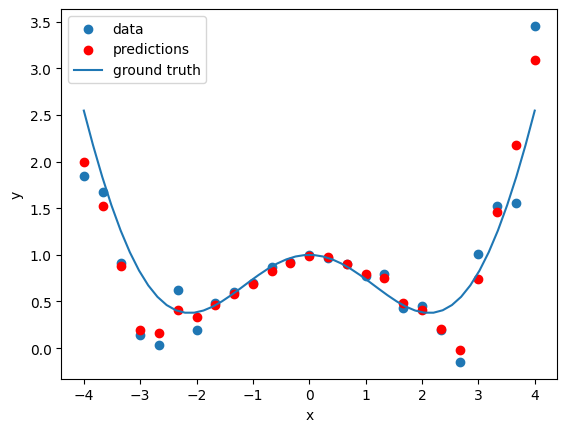

In [7]:
plot_preds(model, train_x, train_y)

In [8]:
# additional code goes here

## Question 2 - Test Error with 200 test points
test_x, test_y = gen_data(200)
output = model(test_x)
test_loss = nn.MSELoss()(output, test_y.unsqueeze(-1))
print(f'Test Error on 200 test points: {test_loss.item():.4f}')

## Question 3 - Increasing the size of the training set
train_x_L, train_y_L = gen_data(250)
model_large_dataset = MLP(1, 1)
model_large_dataset = train_model(train_x_L, train_y_L, model_large_dataset, loss_fn=nn.MSELoss())
output_2 = model_large_dataset(test_x)
test_loss_2 = nn.MSELoss()(output_2, test_y.unsqueeze(-1))
print(f'Test Error on 200 test points with a 10x training dataset: {test_loss.item():.4f}')


Test Error on 200 test points: 0.1270
Epoch: 1/300, loss: 0.4271
Epoch: 21/300, loss: 0.0722
Epoch: 41/300, loss: 0.0570
Epoch: 61/300, loss: 0.0631
Epoch: 81/300, loss: 0.0591
Epoch: 101/300, loss: 0.0668
Epoch: 121/300, loss: 0.0616
Epoch: 141/300, loss: 0.0560
Epoch: 161/300, loss: 0.0566
Epoch: 181/300, loss: 0.0582
Epoch: 201/300, loss: 0.0610
Epoch: 221/300, loss: 0.0659
Epoch: 241/300, loss: 0.0530
Epoch: 261/300, loss: 0.0535
Epoch: 281/300, loss: 0.0552
Test Error on 200 test points with a 10x training dataset: 0.1270


**A:**
1. What's the training error?

The training loss is 0.00385

2. When evaluating on 200 test points what's the test error? Explain the difference.

The test error on 200 test points is 0.07; this is much higher than the training loss.

The model completely overfits on 50% of the training data. As soon as we go to a test set, errors get huge as 50% of the test set will have a very high and uncontrollable loss.

3. What happens when the number of training points is increased? Would this always happen?

The test error doesn't improve. This is due to the fact that our uncertainty is aleatoric and not epistemic. The issue only comes from the inherent noise in the data itself.  

4. [Optional] What's the theoretical best test error, assuming infinite data?
5. [Optional] Estimate $\tilde{\sigma}$. How does it compare to the real $\sigma$?

## 2. Principled Probability 🧠
❔  
**Q3:** MSE is motivated through the negative log likelihood when doing OLS. Review this derivation _(if you never explicitly did this, [look here at chapter 11, pages 371-373](https://probml.github.io/pml-book/book1.html))_. List out your assumptions - do they hold for this problem?

**A:**

Here are out assumptions:
1. Errors are independent and identically distributed random variables
2. Errors are sampled from a normal distribution with the same variance and zero mean

Here, errors are not identically distributed. Even though the errors are sampled from a distribution with mean 0, the variance of the noise is scaled by $x^2$.

❔  
**Q4:** for simplicitly let's continue assuming our data is normally distributed. How can you model heteroscedastic noise? What would you need to change in the previous derivation? _Note - we typically don't a priori know how noisy our data is, e.g. in OLS we don't assume we know the data's variance_.

**A:**
in OLS, we assume that the variance is constant. We therefore use another function to model variance. This also means adapting the loss function to have variance depend on $x_i$ as well.

After training, our model should thus output both a prediction for the function and the noise function.

❔  
**Q5:** using that new assumption you should be able to follow the derivation in **Q3** to get a <ins>new, principled loss function</ins> that incorporates this noise. What is it?

**A:**

We know from the textbook that the current loss function is

$$\mathrm{NLL}\left(\mathbf{w}, \sigma^2\right) = \frac{1}{2\sigma^2}\sum_{n=1}^N (y_n - \hat{y}_n)^2 + \frac{N}{2} \log (2\pi\sigma^2)$$

Now, we simply have to adapt it using a variance that depends on $x_n$. Note that this means that we have to put the leading factor back inside the sum:

$$\mathrm{NLL}(\mathbf{w}, \sigma^2(x_n)) = \sum_{n=1}^{N} \left[\frac{(y_n - \hat{y}_n)^2}{2\sigma^2(x_n)} + \frac{1}{2} \log\left(2\pi\sigma^2(x_n)\right) \right] $$




❔  
**Q6:** let's test this in practice! Implement the loss function, change your model however you see fit, and repeat **Q2**.

🧩  
_Hint:_ if you need to predict a positive parameter usually its easier to predict a real parameter $s$ and then make it positive by mapping $s→\exp(s)$.

In [21]:
def loss_fn_2(output, target): # expecting this signature! target has shape [n_points, 1]
  # write me!
  v = torch.exp(output[:, 1])
  return torch.mean((target.squeeze() - output[:, 0]) ** 2 / (2 * v) + 0.5 * torch.log(2 * torch.pi * v))

## THERE IS AN ERROR IN THIS FUNCTION SOMEWHERE

In [22]:
# write me!
model_3 = MLP(1, 2)
model_3 = train_model(train_x, train_y, model_3, loss_fn=loss_fn_2)

output_3 = model_3(test_x)
test_loss = nn.MSELoss()(output_3[:, 0].unsqueeze(-1), test_y.unsqueeze(-1))
print(f'Test Error on 200 test points with the new model: {test_loss.item():.4f}')

Epoch: 1/300, loss: 1.6538
Epoch: 21/300, loss: 0.7380
Epoch: 41/300, loss: 0.0124
Epoch: 61/300, loss: -0.2575
Epoch: 81/300, loss: -0.7917
Epoch: 101/300, loss: 0.2072
Epoch: 121/300, loss: -0.7942
Epoch: 141/300, loss: -1.0307
Epoch: 161/300, loss: -1.0992
Epoch: 181/300, loss: -0.6978
Epoch: 201/300, loss: -1.0010
Epoch: 221/300, loss: -0.1033
Epoch: 241/300, loss: -0.6987
Epoch: 261/300, loss: -1.0927
Epoch: 281/300, loss: -1.4662
Test Error on 200 test points with the new model: 0.1836


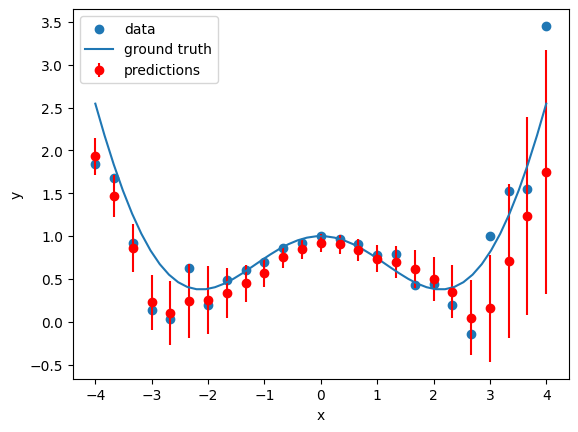

In [23]:
plot_preds(model_3, train_x, train_y)

**A:** We see in our plot that our predictions become more uncertain as we go away from 0. That's a sign that our model seems to work.

❔  
**Q7:** you may have gotten a negative loss at times, which seems quite odd! We were principled, derived everything based on seemingly sound assumptions, checked our code, what went wrong? If we're calculating $-\log(p)$ and $p$ is a probability, so $0\le p\le 1$, this should always be positive. What's wrong here?

**A:** The difference is that here we are dealing with densities.

For densities, we know that their integral must be equal to 1. But it doesn't mean that the densities cannot be greater than one for some values. This is the case for very dense distributions. In out case, since we have a small variance around 0, this means that our loss can be negative.

❔  
**Q8:** if all went well this model should have gotten a lower test MSE than the previous one. _This is awfully peculiar!_ We trained it on a different loss yet it still performed better than an almost identical model trained to minimise MSE directly. Why did this happen? When would we expect this not to occur?

**A:**
This is because MSE assumes all data points are equal, whereas are new error allows the model to learn that there is a higher variance far from 0 and so weights different data points differently based on their uncertainty.

Overall, the model avoids overfitting noise and generalizes better, improving MSE loss.

❔  
**Q9:** are the regular and "uncertainty-aware" models equally powerful? Is there anything that could give one an edge over the other?

**A:**
- The regular model is more powerful (in practice will convergence faster and better) when we are under our assumptions for OLS (the noise is constant)
- The "uncertainty-aware" model is more powerful when the variance depends on the input (as we had here with the $x\epsilon$ term). It can also learn to make variance constant to mimic MSE but will be a bit less effective to do so.

❔  
**Q10:** [Optional] how could we incorporate the other kind of uncertainty into this model?

**A:** _explain!_


# 3. Epilogue 🛌
So that was a cool problem and all, but when is this actually relevant? One interesting use case is for depth-perception in autonomous driving. Here given a picture one needs to predict the distance to each pixel. The noise is extremely heteroscedastic so incorporating uncertainty is beneficial. Here are examples from [this paper](https://arxiv.org/pdf/1703.04977.pdf) - left to right are the input image, ground truth, depth prediction, and aleatoric uncertainty (AKA predicted $\sigma$). In the bottom row one can see there's high uncertainty about the man in the bathroom. In all the pictures the uncertainty generally increases with distance.
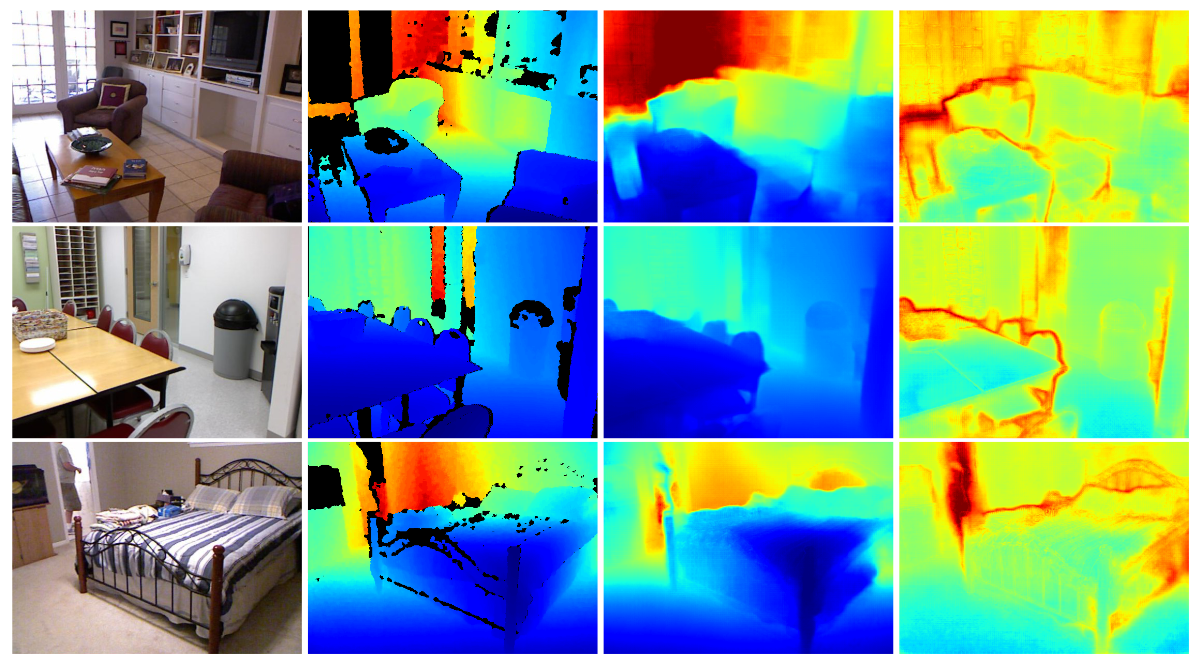